# EDA & Model Development - House Sales; Kings County, USA

[This dataset](https://www.kaggle.com/harlfoxem/housesalesprediction) contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.


In [1]:
# !pip3 install pandas
# !pip3 install pandas-profiling
# !pip3 install sklearn
# !pip3 install ipywidgets --upgrade
# !pip3 install nb_black


In [3]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas_profiling import ProfileReport

%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Explore Data

In [2]:
df = pd.read_csv("../data/raw/kc_house_data.csv")

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Drop Duplicates

Looks like we don't have full duplicate records, but we do have duplicate ID's. For simplicity, lets just drop any row with shared ID

In [4]:
len(df.id.unique()) == len(df)

False

In [5]:
df = df.drop_duplicates(subset=["id"], keep="first")

## Check for Null Values

In [6]:
# check if any null values
True in df.isnull().any(axis=1).tolist()

False

## Create "Listed" Date

In order to mimic a "real" monitoring/logging workflow, we need to emulate the scenario where ground truth values arrive subsequent to when the features/predictions are made available. In this case, that means we need to make a prediction for house price at the time the property is "listed". Then, once the property is sold, we can tie the actual sold amount back to the predicted value. Since this dataset does NOT include a "date listed", we will generate this field artifically.

The `date_listed` field is created by randomly offsetting the `date_sold` by a number of days between 0 and 2 months.



In [7]:
np.random.seed(42)

def random_day_offset(ts: pd._libs.tslibs.timestamps.Timestamp, max_days=60):
    """
    Given a pandas Timestamp, return a new timestep offset to an earlier date by
    a random number of days between 0 and max_days.
    """
    return ts - DateOffset(np.random.randint(0, max_days))

In [8]:
df["date_sold"] = pd.to_datetime(df.date, infer_datetime_format=True)
df["date_listed"] = df.date_sold.apply(lambda x: random_day_offset(x))
df = df.drop(columns=["date"])
df.sort_values(by="date_listed", inplace=True)
df.reset_index(drop=True, inplace=True)

## Lets see how many houses we have listed vs. sold by week

<AxesSubplot:title={'center':'Number of Properties Listed/Sold by Month'}>

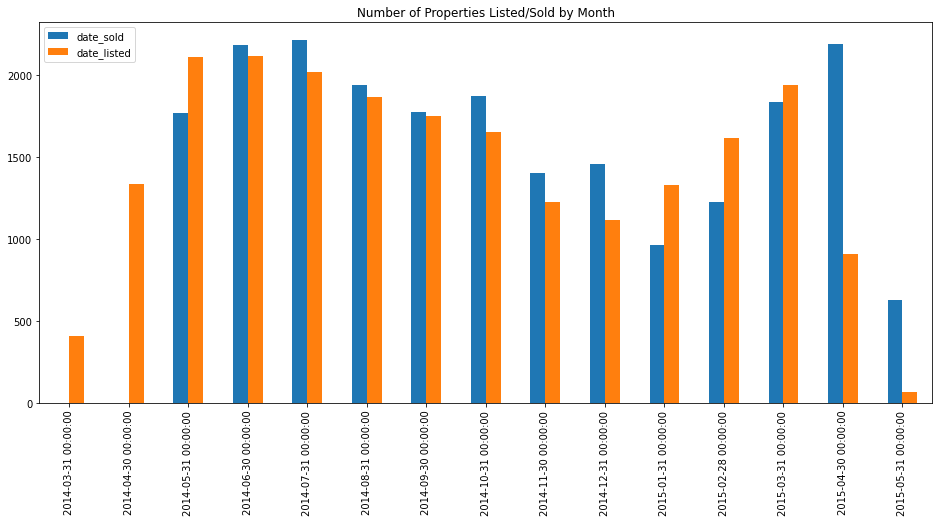

In [12]:
sold = df.set_index("date_sold").groupby(pd.Grouper(freq="M"))["id"].count()
listed = df.set_index("date_listed").groupby(pd.Grouper(freq="M"))["id"].count()

sold.name = "date_sold"
listed.name = "date_listed"

pd.concat([sold, listed], axis=1).plot(
    kind="bar", figsize=(16, 7), title="Number of Properties Listed/Sold by Month"
)

Let's save off the first 6 months of sold records to use as our training data. This means we'll deploy a model trained on data up to 10/31/2014 and start making "production" inference from 11/01/2014 onward.

In [13]:
min_sold_date = df.date_sold.min()
max_sold_date = df.date_sold.max()

train_df = df[
    df.date_sold.between(min_sold_date, "2014-10-31", inclusive="both")
].sort_values("date_sold")
prod_df = df[
    df.date_sold.between("2014-10-31", max_sold_date, inclusive="right")
].sort_values("date_sold")

In [15]:
# # lets save off these dataframes to work with separately

# for name, dataframe in [("train", train_df), ("prod", prod_df)]:
#     path = f"../data/working/{name}_df.pkl"
#     dataframe.to_pickle(path)

**Data/Process Workflow:**

0.a Train model on first half of data and deploy model to be "in production" for the second half of data

0.b Set ENV_VAR that keeps track of current month/date as a counter

Job 1. Query all properies LISTED in the last X (lets say 2) months
  - Make price predictions on those properties via the deployed model
  - Log all input features and prediction for each record
  - Save a mapping (in the table itself?) between prediction UUID and listing ID
  - Repeat this process every 5 minutes to simulate a new X months of data listings + increment ENV_VAR
  
Job 2. Query all properties SOLD in the last X months
  - Use `cdsw` library to log the true sale value into the UUID record
  
  
Job 3. Build report for properties SOLD in the last X months
  - Use the ENV_VAR to control this

## Pandas Profiling

In [16]:
# ProfileReport(df, title="Pandas Profile Report")

## Modeling

**NOTE TO SELF**

- might want to do some more EDA
- normalize target feature?? np.log
- pair plot

Example: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

In [4]:
prod_path = "../data/working/prod_df.pkl"
prod_df = pd.read_pickle(prod_path)

In [5]:
prod_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_sold,date_listed
10721,2274000026,353000.0,3,2.50,1250,864,3.0,0,0,3,...,0,2004,0,98115,47.6978,-122.318,1330,2298,2014-11-01,2014-09-16
12942,7857000732,350000.0,3,1.75,2090,6258,1.0,0,0,3,...,700,1956,0,98108,47.5503,-122.301,1790,5793,2014-11-01,2014-10-26
10758,8085400586,1750000.0,4,2.75,3560,8975,2.0,0,0,3,...,0,2014,0,98004,47.6322,-122.209,3440,12825,2014-11-01,2014-09-16
13121,1854900410,644500.0,4,2.50,2990,5342,2.0,0,0,3,...,0,2004,0,98074,47.6124,-122.009,2990,5936,2014-11-01,2014-10-29
11253,7852020760,399000.0,3,2.50,1740,3690,2.0,0,0,3,...,0,2000,0,98065,47.5345,-121.867,2100,4944,2014-11-01,2014-09-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21138,1422700040,183000.0,3,1.00,1170,7320,1.0,0,0,3,...,0,1962,0,98188,47.4685,-122.282,2040,7320,2015-05-14,2015-04-18
21435,8149600265,725000.0,4,1.75,1980,5850,1.0,0,1,4,...,600,1960,0,98116,47.5607,-122.391,1810,5850,2015-05-14,2015-05-13
21327,7923600250,450000.0,5,2.00,1870,7344,1.5,0,0,3,...,0,1960,0,98007,47.5951,-122.144,1870,7650,2015-05-15,2015-04-27
21282,5101400871,445500.0,2,1.75,1390,6670,1.0,0,0,3,...,670,1941,0,98115,47.6914,-122.308,920,6380,2015-05-24,2015-04-24


In [6]:
prod_df.shape

(9695, 22)

In [3]:
train_path = "../data/working/train_df.pkl"
train_df = pd.read_pickle(train_path)

In [25]:
train_df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date_sold', 'date_listed'],
      dtype='object')

In [158]:
import scipy
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV

In [98]:
X_train = train_df.drop("price", axis=1)
y_train = train_df.price

In [160]:
# define the columns I want to use and the intended data type
num_cols = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot"]
cat_cols = ["waterfront", "zipcode", "condition", "view"]

In [169]:
# define our numerical and categorical pipelines
num_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("standardize", StandardScaler()),
        ("scale", MinMaxScaler()),
    ]
)
cat_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("one-hot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [170]:
# combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_pipe, num_cols),
        ("categorical", cat_pipe, cat_cols),
    ]
)

In [181]:
# define estimator - Transformed Target Regressor takes the log of the target variable to normalize
estimator = TransformedTargetRegressor(
    regressor=Ridge(alpha=0.1), func=np.log10, inverse_func=scipy.special.exp10
)

# construct full pipeline
full_pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", estimator)])

In [182]:
gscv = GridSearchCV(
    full_pipe,
    param_grid={"model__regressor__alpha": np.arange(0.1, 1, 0.1)},
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('standardize',
                                                                                          StandardScaler()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                      

In [157]:
gscv.best_score_

-89866.72188242197

In [184]:
gscv.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('standardize',
                                                                   StandardScaler()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
       

In [185]:
import pickle

In [186]:
with open("../model.pkl", "wb") as f:
    pickle.dump(gscv.best_estimator_, f)

In [191]:
full_pipe.named_steps["preprocess"].ipynb_checkpoints/

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('standardize',
                                                  StandardScaler()),
                                                 ('scale', MinMaxScaler())]),
                                 ['bedrooms', 'bathrooms', 'sqft_living',
                                  'sqft_lot']),
                                ('categorical',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['waterfront', 'zipcode', 'condition',
                                  'vie

In [192]:
a = full_pipe.named_steps["preprocess"]

## To Do

Include section where I analyze / interpret linear model lik done here: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

Also include write ups for why and what ridge regression is.

In [5]:
# For this first pass, lets drop latitute, longitude, yr_renovated
df = df.drop(columns=['lat', 'long', 'yr_renovated'])

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
date,,,,,,,,,,,,,,,,
2014-05-02,437500.0,3,2.25,1970,35100,2.0,0,0,4,9,1970,0,1977,98027,2340,35100
2014-05-02,790000.0,3,2.50,2600,4750,1.0,0,0,4,9,1700,900,1951,98117,2380,4750
2014-05-02,675000.0,5,2.50,2820,67518,2.0,0,0,3,8,2820,0,1979,98029,2820,48351
2014-05-02,555000.0,4,2.50,3310,6500,2.0,0,0,3,8,3310,0,2012,98065,2380,5000
2014-05-02,440000.0,4,2.25,2160,8119,1.0,0,0,3,8,1080,1080,1966,98006,1850,9000


### Split Data

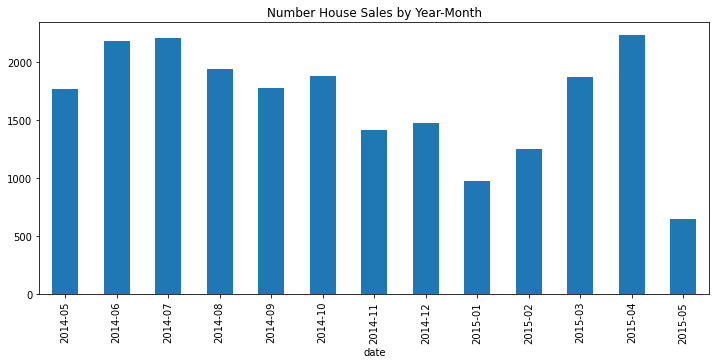

In [7]:
df.groupby(df.index.to_period('M')).size().plot(kind='bar', figsize=(12,5), title='Number House Sales by Year-Month');

**Lets train on all of 2015 data and predict on 2015**

In [8]:
train, test = df.loc[df.index.year==2014], df.loc[df.index.year!=2014]

X_train, y_train = train.loc[:, train.columns != 'price'], train['price']
X_test, y_test = test.loc[:, test.columns != 'price'], test['price']

In [9]:
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score

In [10]:
rfr = RandomForestRegressor(n_estimators=50, random_state=42)

In [11]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

Regression performance on all of 2015 data:

In [12]:
rfr.score(X_test, y_test)

0.7937752815712188

In [13]:
explained_variance_score(y_test, rfr.predict(X_test))

0.7988137349857601

In [14]:
sqrt(mean_squared_error(y_test, rfr.predict(X_test)))

164761.81862499967

In [15]:
rfr.predict([X_test.iloc[0]])

array([416350.])

## Save Model 

In [16]:
import pickle

In [17]:
# with open('models/price_regressor.pkl', 'wb') as f:
#     pickle.dump(rfr, f)

## Test Model Metrics

In [18]:
import time
from predict import predict


Not running in a model replica, so using a local development
version of the model metrics service. Please use the following
CRN's to consume metrics:
   model_crn: "crn:cdp:ml:::workspace:dev/model" (cdsw.dev_model_crn)
   model_build_crn: "crn:cdp:ml:::workspace:dev/model-build" (cdsw.dev_model_build_crn)
   model_deployment_crn: "crn:cdp:ml:::workspace:dev/model-deployment" (cdsw.dev_model_deployment_crn)



In [34]:
X_jan15 = X_test.loc[X_test.index.month==1]

In [35]:
start_timestamp_ms=int(round(time.time() * 1000))
yhat_jan15 = predict(X_jan15)
end_timestamp_ms=int(round(time.time() * 1000))

In [36]:
yhat_jan15.keys()

dict_keys(['prediction', 'model_deployment_crn', 'uuid'])

In [38]:
yhat_jan15

{'prediction': None,
 'model_deployment_crn': 'crn:cdp:ml:::workspace:dev/model-deployment',
 'uuid': 'b954b2eb-309d-49a7-9394-3854ae2dc8f3'}

In [32]:
yhat_jan15['model_deployment_crn']

'crn:cdp:ml:::workspace:dev/model-deployment'

In [29]:
yhat_jan15['uuid']

'22df7bc4-37bd-4e63-80f5-a537461f135b'

### Predict individually

In [56]:
uuids = []
for i in range(len(X_jan15)):
    response = predict([X_jan15.iloc[i].to_numpy()])

RESULT:  [416350.]
RESULT:  [593346.]
RESULT:  [545018.]
RESULT:  [547519.]
RESULT:  [812545.3]
RESULT:  [559692.]
RESULT:  [576331.]
RESULT:  [235289.52]
RESULT:  [1290730.46]
RESULT:  [284057.24]
RESULT:  [560150.9]
RESULT:  [400849.88]
RESULT:  [324814.28]
RESULT:  [675028.38]
RESULT:  [256075.4]
RESULT:  [950270.]
RESULT:  [245892.]
RESULT:  [545822.26]
RESULT:  [301243.88]
RESULT:  [439869.]
RESULT:  [769145.18]
RESULT:  [385411.]
RESULT:  [398120.]
RESULT:  [1436543.]
RESULT:  [255908.]
RESULT:  [534898.76]
RESULT:  [771781.]
RESULT:  [474507.]
RESULT:  [255294.]
RESULT:  [305304.88]
RESULT:  [570953.4]
RESULT:  [226071.]
RESULT:  [269611.12]
RESULT:  [221117.5]
RESULT:  [560825.5]
RESULT:  [278910.4]
RESULT:  [337632.]
RESULT:  [315121.5]
RESULT:  [762612.6]
RESULT:  [331647.]
RESULT:  [679393.22]
RESULT:  [486057.3]
RESULT:  [827929.4]
RESULT:  [367106.]
RESULT:  [412432.]
RESULT:  [456912.2]
RESULT:  [437928.9]
RESULT:  [764127.6]
RESULT:  [1319665.]
RESULT:  [479579.32]
RESUL

KeyboardInterrupt: 

In [158]:
X_jan15

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
date,,,,,,,,,,,,,,,
2015-01-02,3,2.5,1950,4949,2.0,0,0,3,7,1950,0,2009,98065,2200,5740
2015-01-02,4,3.5,2770,3330,2.0,0,0,3,8,1970,800,2001,98052,2180,3380
2015-01-02,4,2.5,1880,3853,2.0,0,0,3,8,1880,0,2010,98027,1890,3078
2015-01-02,3,2.5,2400,6474,1.0,0,2,3,8,1560,840,1964,98177,2340,10856
2015-01-02,4,3.5,3780,7769,2.0,0,0,3,9,3110,670,2001,98052,3310,7945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-30,4,3.0,2060,9138,1.0,0,0,3,8,1430,630,1992,98092,2250,7820
2015-01-30,4,1.5,2650,34000,2.0,0,0,4,7,2650,0,1930,98028,1960,34000
2015-01-30,3,2.5,1670,4020,2.0,0,0,3,7,1670,0,2009,98118,1670,4020


In [166]:
X_jan15.iloc[i].to_numpy()

array([3.0000e+00, 2.5000e+00, 1.9500e+03, 4.9490e+03, 2.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0000e+00, 7.0000e+00, 1.9500e+03,
       0.0000e+00, 2.0090e+03, 9.8065e+04, 2.2000e+03, 5.7400e+03])

In [154]:
X_jan15.iloc[0]

bedrooms             3.0
bathrooms            2.5
sqft_living       1950.0
sqft_lot          4949.0
floors               2.0
waterfront           0.0
view                 0.0
condition            3.0
grade                7.0
sqft_above        1950.0
sqft_basement        0.0
yr_built          2009.0
zipcode          98065.0
sqft_living15     2200.0
sqft_lot15        5740.0
Name: 2015-01-02 00:00:00, dtype: float64

In [ ]:
for i in ran

### Call Model function

In [ ]:
cdsw.track_metric()

In [150]:
X_jan15

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
date,,,,,,,,,,,,,,,
2015-01-02,3,2.5,1950,4949,2.0,0,0,3,7,1950,0,2009,98065,2200,5740
2015-01-02,4,3.5,2770,3330,2.0,0,0,3,8,1970,800,2001,98052,2180,3380
2015-01-02,4,2.5,1880,3853,2.0,0,0,3,8,1880,0,2010,98027,1890,3078
2015-01-02,3,2.5,2400,6474,1.0,0,2,3,8,1560,840,1964,98177,2340,10856
2015-01-02,4,3.5,3780,7769,2.0,0,0,3,9,3110,670,2001,98052,3310,7945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-30,4,3.0,2060,9138,1.0,0,0,3,8,1430,630,1992,98092,2250,7820
2015-01-30,4,1.5,2650,34000,2.0,0,0,4,7,2650,0,1930,98028,1960,34000
2015-01-30,3,2.5,1670,4020,2.0,0,0,3,7,1670,0,2009,98118,1670,4020


In [151]:

cdsw.call_model(model_access_key=None, api_key=None, ipt=X_jan15)

RuntimeError: Input must be a dict

### Fetch model metrics

In [13]:
import cdsw

In [40]:
# cdsw.track_metric('test', 'TESTING VALUE')

In [41]:
data = cdsw.read_metrics(model_deployment_crn=cdsw.dev_model_deployment_crn,
                         dev=True)
#                          start_timestamp_ms=start_timestamp_ms, 
#                          end_timestamp_ms=end_timestamp_ms,)

In [42]:
data['metrics']

[{'modelDeploymentCrn': 'crn:cdp:ml:::workspace:dev/model-deployment',
  'modelBuildCrn': 'crn:cdp:ml:::workspace:dev/model-build',
  'modelCrn': 'crn:cdp:ml:::workspace:dev/model-deployment',
  'startTimeStampMs': 1634658094877,
  'endTimeStampMs': 1634658094877,
  'predictionUuid': '667446bf-46f1-4530-bae4-1578d84032ad',
  'metrics': {}},
 {'modelDeploymentCrn': 'crn:cdp:ml:::workspace:dev/model-deployment',
  'modelBuildCrn': 'crn:cdp:ml:::workspace:dev/model-build',
  'modelCrn': 'crn:cdp:ml:::workspace:dev/model-deployment',
  'startTimeStampMs': 1634658100538,
  'endTimeStampMs': 1634658100538,
  'predictionUuid': 'b954b2eb-309d-49a7-9394-3854ae2dc8f3',
  'metrics': {}}]

In [136]:
cdsw.dev_model_deployment_crn

'crn:cdp:ml:::workspace:dev/model-deployment'

In [1]:
t = {'a':5, 'b':10}

In [2]:
t.get('a')

5

In [14]:
?? cdsw

Type:        module
String form: <module 'cdsw' from '/usr/local/lib/python3.6/site-packages/cdsw.py'>
File:        /usr/local/lib/python3.6/site-packages/cdsw.py
Source:     
"""
CDSW
====

Utilities for Python on Cloudera Data Science Workbench.
"""
import os
import shutil
import sys
import time
import traceback
import warnings
import re
import urllib
import base64
import uuid
import subprocess

import requests
import json

try:
    # python 2
    import futures
except ImportError:
    # python 3
    import concurrent.futures as futures

# Make isinstance(my_string, basestring) work in both Python 2 and 3
try:
    basestring
except NameError:
    basestring = str

__all__ = ["get_auth", "launch_workers", "list_workers", "stop_workers", "await_workers", "track_file", "track_metric",
           "call_model", "model_metrics", "read_metrics", "track_delayed_metrics", "track_aggregate_metrics"]

# Thread pool size configuration
THREAD_POOL_SIZE = 10

# metric data object
_current_metrics 